In [1]:
%load_ext autoreload
%autoreload 2
    

import pickle
import numpy as np 
from matplotlib import pyplot as plt
import itertools

from src.utils.generate_query import generate_queries
from src.blast.hashtable_generation_inference import consensus_seq_match
from src.blast.eval import iou
from sklearn.metrics import roc_auc_score


In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
reference_matrix = pickle.load(open('src/data/reference_matrix.p', 'rb'))

# Examples generations

Generate easy/hard cases of length 100:

- very hard case: the max probability is less than 0.7
- hard case: the max probabiity is between 0.7 and 0.8
- intermediate case: the max probability is between 0.8 and 0.9
- easy case: the max probability is larger than 0.9

For each case, randomly select 100 position, sample 100 sequences over each position in following categories:
- no indel del substitution 
- with substitution 10% times 
- with substitution 5% times 
- with substitution 1% times 
- with substitution 1% times and indel del 
- with substitution 1% times, indel del, size 500
- with substitution 1% times, indel del, size 1000

In [4]:
# max_prob_reference_matrix = np.max(reference_matrix, axis=1)
# max_probs_ma = moving_average(max_prob_reference_matrix, 100)

# very_hard_cases = np.where(max_probs_ma < 0.7)[0]
# hard_cases = np.where((max_probs_ma >= 0.7)&(max_probs_ma < 0.8))[0]
# intermediate_cases = np.where((max_probs_ma >= 0.8)&(max_probs_ma < 0.9))[0]
# easy_cases = np.where(max_probs_ma >= 0.9)[0]


# very_hard_examples = list(very_hard_cases)

# np.random.shuffle(hard_cases)
# hard_examples = list(hard_cases[:100])

# np.random.shuffle(intermediate_cases)
# intermediate_examples = list(intermediate_cases[:100])

# np.random.shuffle(easy_cases)
# easy_examples = list(easy_cases[:100])

In [5]:
# difficulty_pos = {
#     'easy': easy_examples,
#     'intermediate': intermediate_examples,
#     'hard': hard_examples,
#     'very_hard': very_hard_examples
# }

# configs = [
#     {'sub':0, 'indel':False, 'size': 100},
#     {'sub':0.1, 'indel':False, 'size': 100},
#     {'sub':0.05, 'indel':False, 'size': 100},
#     {'sub':0.01, 'indel':False, 'size': 100},
#     {'sub':0.01, 'indel':True, 'size': 100},
#     {'sub':0.01, 'indel':True, 'size': 500},
#     {'sub':0.01, 'indel':True, 'size': 1000},
# ]

# difficulties = ['very_hard', 'hard', 'intermediate', 'easy']

# all_configs = []
# for c in configs:
#     for d in difficulties:
#         c2 = c.copy()

#         #print(d) 
#         c2['difficulty'] = d
#         all_configs.append(c2)
# all_examples = []
# for config in all_configs:
#     print(config)
#     sub = config['sub']
#     non_substitution_proba = 1- sub
#     with_substitution = sub > 0 
#     indel = config['indel']
#     size = config['size']
#     difficulty = config['difficulty']
#     positions = difficulty_pos[difficulty]
    
#     examples= generate_queries(reference_matrix, size, positions, num=100, with_substitution=with_substitution, with_indel=indel,
#                     non_substitution_proba=non_substitution_proba
#                     )
#     config['examples'] = examples
#     all_examples.append(config)  
# pickle.dump(all_examples, open('all_examples','wb'))

In [11]:
all_examples = pickle.load(open('all_examples','rb'))

# Evalutation of baseline algorithm

## 1. Evaluate seed hitting

To evaluate seed hitting, given seed lengh = 11, a query of length 100 have 90 chance to hit the reference sequence

metrics per sequence:
- hit rate = # of hits / (size - 11 +1)
- number of matches (including incorrect matches)

metric for a set of examples:
- distribution of hit rate
- distributoin of number of matches
- portion of cases with 0 hit
    - portion of cases where seed matching algorithm fail completely
    

Two seed matching algorithm in consideration:
- consensus seed matching 
- loose seed matching (table built based on nt passing a given threshold), with following probability threhsold 0.15 -> 0.4


In [14]:
table_data = pickle.load(open('src/data/hashtable.p','rb'))
table_data_15 = pickle.load(open('src/data/hashtable_015.p','rb'))
table_data_16 = pickle.load(open('src/data/hashtable_016.p','rb'))
table_data_17 = pickle.load(open('src/data/hashtable_017.p','rb'))
table_data_18 = pickle.load(open('src/data/hashtable_018.p','rb'))
table_data_19 = pickle.load(open('src/data/hashtable_019.p','rb'))
table_data_20 = pickle.load(open('src/data/hashtable_020.p','rb'))
table_data_25 = pickle.load(open('src/data/hashtable_025.p','rb'))
table_data_30 = pickle.load(open('src/data/hashtable_030.p','rb'))
table_data_35 = pickle.load(open('src/data/hashtable_035.p','rb'))
table_data_40 = pickle.load(open('src/data/hashtable_040.p','rb'))


In [15]:
def seed_hit_evalutation(examples, table_data, method, total_hits):
    
    for entry in examples:

        label_pos = entry['pos']
        query = entry['query']    
        output = consensus_seq_match(table_data, query)
        entry[method] = output
        match_num = 0
        
        match_num = len([x for x in output if x['seed_matching_result']['query_idx']+label_pos == x['seed_matching_result']['ref_idx']])  
        acc = match_num / total_hits
        entry[method+'_hit_rate'] = acc 
        entry[method+'_matches'] = len(output)
        

In [16]:
all_examples[0].keys()

dict_keys(['sub', 'indel', 'size', 'difficulty', 'examples'])

In [17]:
for examples_set in all_examples[:4]:
    
    size = examples_set['size']
    total_hits = size -10
    seed_hit_evalutation(examples_set['examples'], table_data, 'consensus_matching', total_hits)
    
    seed_hit_evalutation(examples_set['examples'], table_data_15, 'seed_matching_nt15', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_20, 'seed_matching_nt20', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_25, 'seed_matching_nt25', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_30, 'seed_matching_nt30', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_35, 'seed_matching_nt35', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_40, 'seed_matching_nt40', total_hits)

    seed_hit_evalutation(examples_set['examples'], table_data_16, 'seed_matching_nt16', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_17, 'seed_matching_nt17', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_18, 'seed_matching_nt18', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_19, 'seed_matching_nt19', total_hits)


In [312]:
all_examples[1]['sub']

0

In [19]:
standard_testing_cases = [x for x in all_examples if x['sub']==0.01 and x['indel'] and x['size']==100]

In [20]:
for examples_set in standard_testing_cases:
    
    size = examples_set['size']
    total_hits = size -10
    seed_hit_evalutation(examples_set['examples'], table_data, 'consensus_matching', total_hits)
    
    seed_hit_evalutation(examples_set['examples'], table_data_15, 'seed_matching_nt15', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_20, 'seed_matching_nt20', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_25, 'seed_matching_nt25', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_30, 'seed_matching_nt30', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_35, 'seed_matching_nt35', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_40, 'seed_matching_nt40', total_hits)

    seed_hit_evalutation(examples_set['examples'], table_data_16, 'seed_matching_nt16', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_17, 'seed_matching_nt17', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_18, 'seed_matching_nt18', total_hits)
    seed_hit_evalutation(examples_set['examples'], table_data_19, 'seed_matching_nt19', total_hits)


### 1.1 Original algorihtm: consensus matching

seed algorithm 1: seed table is filled with consensus sequence from the reference matrix

### 1.1.1 Test on Simple Cases

Simple cases with no indel and subsitution


In [21]:
matches = [[x['consensus_matching_matches'] for x in examples_set['examples']] for examples_set in all_examples[:4]]
hit_rates = [[x['consensus_matching_hit_rate'] for x in examples_set['examples']] for examples_set in all_examples[:4]]



In [202]:
nt_0hit_cases_portion = []
for example_set in all_examples[:4]:
    result = [example_set['difficulty']]
    key = 'consensus_matching_hit_rate'
    r = len([x for x in example_set['examples'] if x[key] == 0]) / len(all_examples[0]['examples'] )
    result.append(r)
    nt_0hit_cases_portion.append(result)


nt_avg_hit_rate = []
for example_set in all_examples[:4]:
    result = [example_set['difficulty']]
    key = 'consensus_matching_hit_rate'
    r = np.mean([x[key] for x in example_set['examples']])
    result.append(r)
    nt_avg_hit_rate.append(result)

mean_matches_num = []
for example_set in all_examples[:4]:
    result = [example_set['difficulty']]
    key = 'consensus_matching_matches'
    r = np.mean([x[key] for x in example_set['examples']])
    result.append(r)
    mean_matches_num.append(result)

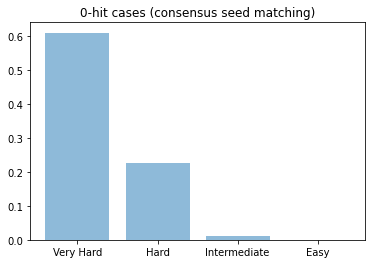

In [203]:
objects = ('Very Hard', 'Hard', 'Intermediate', 'Easy')
y_pos = np.arange(len(objects))
performance = [x[1] for x in nt_0hit_cases_portion]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('0-hit cases (consensus seed matching)')

plt.show()


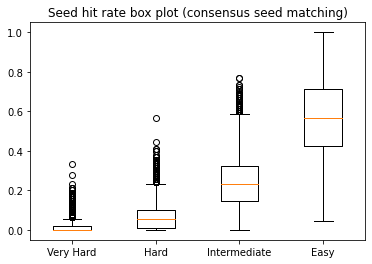

In [30]:
data = hit_rates
plt.boxplot(data)
plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])
plt.title('Seed hit rate box plot (consensus seed matching)')
plt.show()

### 1.2 Improved seeding algorithm

seeding algorithm 2: at each nt position, all letters with probability > than threshold are considered, seed table cases are all combinations of possible letters

### 1.2.1 Test on simple cases

Simple cases with no indel and subsitution

In [26]:
nt_0hit_cases_portion = []
for example_set in all_examples[:4]:
    result = [example_set['difficulty']]
    for rate in [15,16,17,18,19,20,25,30,35,40]:
        key = 'seed_matching_nt{0}_hit_rate'.format(rate)
        r = len([x for x in example_set['examples'] if x[key] == 0]) / len(all_examples[0]['examples'] )
        result.append(r)
    nt_0hit_cases_portion.append(result)


nt_avg_hit_rate = []
for example_set in all_examples[:4]:
    result = [example_set['difficulty']]
    for rate in [15,16,17,18,19,20,25,30,35,40]:
        key = 'seed_matching_nt{0}_hit_rate'.format(rate)
        r = np.mean([x[key] for x in example_set['examples']])
        result.append(r)
    nt_avg_hit_rate.append(result)

mean_matches_num = []
for example_set in all_examples[:4]:
    result = [example_set['difficulty']]
    for rate in [15,16,17,18,19,20,25,30,35,40]:
        key = 'seed_matching_nt{0}_matches'.format(rate)
        r = np.mean([x[key] for x in example_set['examples']])
        result.append(r)
    mean_matches_num.append(result)

#### 1.2.1.1 Test 0.15 threshold 

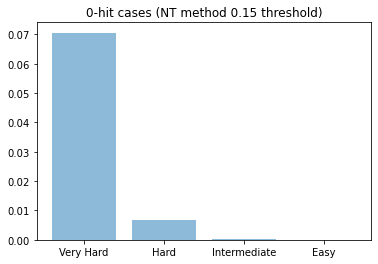

In [28]:
data = [x[1] for x in nt_0hit_cases_portion]
objects = ('Very Hard', 'Hard', 'Intermediate', 'Easy')
y_pos = np.arange(len(objects))
performance = data

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('0-hit cases (NT method 0.15 threshold)')

plt.show()


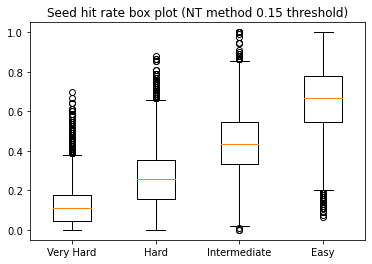

In [406]:
data =  [[x['seed_matching_nt15_hit_rate'] for x in examples_set['examples']] for examples_set in all_examples[:4]]

plt.boxplot(data)
plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])
plt.title('Seed hit rate box plot (NT method 0.15 threshold)')
plt.show()

#### 1.2.1.2 Result for different threshold

Consider the following threshold 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.25, 0.3, 0.35, 0.4, calculate the following states:

- zero hit cases: portion of examples where we completely fail to match any correct seed
- average hit rate: average hit rate of all examples 
- average match number: average number of matches produced (including incorrect ones)

zero hit cases

In [33]:
import pandas as pd

In [34]:
pd.DataFrame(nt_0hit_cases_portion, columns=['Difficulty', 'nt15', 'nt16', 'nt17','nt18', 'nt19','nt20','nt25','nt30','nt35','nt40'])

,Difficulty,nt15,nt16,nt17,nt18,nt19,nt20,nt25,nt30,nt35,nt40
0,very_hard,0.070602,0.086265,0.255301,0.554819,0.555542,0.592892,0.609277,0.609277,0.609277,0.609277
1,hard,0.006867,0.015301,0.048193,0.185060,0.194458,0.217349,0.225422,0.225422,0.225422,0.225422
2,intermediate,0.000241,0.000843,0.001566,0.009157,0.010361,0.011446,0.011807,0.011807,0.011807,0.011807
3,easy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


average hit rate

In [35]:
pd.DataFrame(nt_avg_hit_rate, columns=['Difficulty', 'nt15', 'nt16', 'nt17','nt18', 'nt19','nt20','nt25','nt30','nt35','nt40'])

,Difficulty,nt15,nt16,nt17,nt18,nt19,nt20,nt25,nt30,nt35,nt40
0,very_hard,0.126143,0.110827,0.057189,0.019849,0.019637,0.017266,0.016187,0.016187,0.016187,0.016187
1,hard,0.266598,0.212374,0.144196,0.081732,0.078631,0.071527,0.069513,0.069513,0.069513,0.069513
2,intermediate,0.440067,0.387402,0.331070,0.256550,0.251058,0.244841,0.243361,0.243361,0.243361,0.243361
3,easy,0.662589,0.634354,0.607712,0.569883,0.568284,0.565728,0.565172,0.565172,0.565172,0.565172


matches number

In [36]:
pd.DataFrame(mean_matches_num, columns=['Difficulty', 'nt15', 'nt16', 'nt17','nt18', 'nt19','nt20','nt25','nt30','nt35','nt40'])

,Difficulty,nt15,nt16,nt17,nt18,nt19,nt20,nt25,nt30,nt35,nt40
0,very_hard,1234.684337,912.764578,131.368916,28.225181,26.560843,24.502892,23.796867,23.796867,23.796867,23.796867
1,hard,1331.325400,989.405600,161.649400,41.546900,38.897000,35.796800,34.688700,34.688700,34.688700,34.688700
2,intermediate,1586.630600,1180.472300,264.237100,101.200700,96.533500,89.591900,87.931800,87.931800,87.931800,87.931800
3,easy,1464.007500,1091.832400,244.534900,109.510200,106.004500,102.368200,101.138500,101.138500,101.138500,101.138500


### 1.2.2 Test on complex cases

standard cases:
- subsitution 1%
- with indel 
- 100 length query

compute the same stats as 1.2.1.2

In [37]:
nt_0hit_cases_portion = []
for example_set in standard_testing_cases:
    result = [example_set['difficulty']]
    for rate in [15,16,17,18,19,20,25,30,35,40]:
        key = 'seed_matching_nt{0}_hit_rate'.format(rate)
        r = len([x for x in example_set['examples'] if x[key] == 0]) / len(all_examples[0]['examples'] )
        result.append(r)
    nt_0hit_cases_portion.append(result)


nt_avg_hit_rate = []
for example_set in standard_testing_cases:
    result = [example_set['difficulty']]
    for rate in [15,16,17,18,19,20,25,30,35,40]:
        key = 'seed_matching_nt{0}_hit_rate'.format(rate)
        r = np.mean([x[key] for x in example_set['examples']])
        result.append(r)
    nt_avg_hit_rate.append(result)

mean_matches_num = []
for example_set in standard_testing_cases:
    result = [example_set['difficulty']]
    for rate in [15,16,17,18,19,20,25,30,35,40]:
        key = 'seed_matching_nt{0}_matches'.format(rate)
        r = np.mean([x[key] for x in example_set['examples']])
        result.append(r)
    mean_matches_num.append(result)

zero hit cases

In [38]:
pd.DataFrame(nt_0hit_cases_portion, columns=['Difficulty', 'nt15', 'nt16', 'nt17','nt18', 'nt19','nt20','nt25','nt30','nt35','nt40'])

,Difficulty,nt15,nt16,nt17,nt18,nt19,nt20,nt25,nt30,nt35,nt40
0,very_hard,0.150000,0.171566,0.361687,0.633494,0.633855,0.669518,0.686988,0.686988,0.686988,0.686988
1,hard,0.093253,0.113976,0.170120,0.327952,0.337108,0.358916,0.368675,0.368675,0.368675,0.368675
2,intermediate,0.064578,0.070361,0.080000,0.110843,0.113373,0.116867,0.118072,0.118072,0.118072,0.118072
3,easy,0.053976,0.056265,0.058554,0.061325,0.061566,0.061687,0.061687,0.061687,0.061687,0.061687


average hit rate

In [39]:
pd.DataFrame(nt_avg_hit_rate, columns=['Difficulty', 'nt15', 'nt16', 'nt17','nt18', 'nt19','nt20','nt25','nt30','nt35','nt40'])

,Difficulty,nt15,nt16,nt17,nt18,nt19,nt20,nt25,nt30,nt35,nt40
0,very_hard,0.101183,0.088924,0.045206,0.015688,0.015573,0.013679,0.012780,0.012780,0.012780,0.012780
1,hard,0.208831,0.165418,0.112684,0.063574,0.061436,0.055880,0.054211,0.054211,0.054211,0.054211
2,intermediate,0.335111,0.295596,0.251452,0.193646,0.189474,0.185204,0.184064,0.184064,0.184064,0.184064
3,easy,0.498004,0.476657,0.455500,0.426182,0.424797,0.422837,0.422357,0.422357,0.422357,0.422357


matches number

In [40]:
pd.DataFrame(mean_matches_num, columns=['Difficulty', 'nt15', 'nt16', 'nt17','nt18', 'nt19','nt20','nt25','nt30','nt35','nt40'])

,Difficulty,nt15,nt16,nt17,nt18,nt19,nt20,nt25,nt30,nt35,nt40
0,very_hard,1230.171807,909.528675,129.761205,27.632651,25.962651,23.971325,23.282771,23.282771,23.282771,23.282771
1,hard,1319.616700,980.713500,157.311800,39.439700,36.890300,33.931100,32.898600,32.898600,32.898600,32.898600
2,intermediate,1560.234700,1160.177300,252.311300,93.772600,89.409500,82.932700,81.363600,81.363600,81.363600,81.363600
3,easy,1443.843400,1075.705200,232.204400,99.730200,96.368000,92.927700,91.769000,91.769000,91.769000,91.769000


## 2. Evaluate ungapped extention

given a reference | array P and nucleotide index i

two methods are compared:

- default scoring function is $S=P_i - \sum_{j\neq i}P_j$
- modified scoring function
    - if i == argmax{P},  $S=max(0, P_i - \sum_{j\neq i}P_j)$
    - else $S= P_i - \sum_{j\neq i}P_j$

## 2.1 extension length

this section can be evaluated independent of the seed hitting performance

for each query, we assume perfect seed hitting: for query of length 100, every query has 90 hits at correct position, so for each sequence we do 90 ungapped extention, compute extention length

compute extension length over 100 random cases for 4 difficulties

In [43]:
import random 
base_examples = all_examples[:4]

In [44]:
test_extension_ability_examples = []

for example_cases in base_examples:
    examples = example_cases['examples'] 
    random.shuffle(examples)
    
    test_extension_ability_examples.append(
        examples[:100]
    )
    
    

In [12]:
from src.blast.ungapped_extension import ungapped_extension

In [52]:
cases= evaluate_ungapped_extenison(test_extension_ability_examples[0])

In [74]:
def evaluate_ungapped_extenison(examples, delta=1, scoring_function='sum_proba_score_correct0', use_seed_result=False, seed_result_key='consensus_matching'):
        
    all_data = []
    for idx, example  in enumerate(examples):

        query = example['query']
        label_pos = example['pos']
        if not use_seed_result:
            seed_result = [
                {'seed_matching_result': {'query_idx':idx, 'ref_idx': idx+label_pos, 'score':0}} for idx in range(90)
            ]

        else:
            seed_result = example[seed_result_key]
        data = ungapped_extension(query, seed_result, 'src/data/reference_matrix.p', 11, delta, scoring_function)
        for x in data:
            ungapped_left_idx, ungapped_right_idx = x['ungapped_extension_result']['ref_left_idx'],  x['ungapped_extension_result']['ref_right_idx']
            ref_left_idx, ref_right_idx = label_pos, label_pos+99
            x['ungapped_extension_iou'] = iou((ref_left_idx, ref_right_idx), (ungapped_left_idx, ungapped_right_idx))
            
        if use_seed_result:
            key = 'original'
        else:
            key= 'simulated'
        #example['ungapped_extension_result_{0}_delta_{1}_{2}'.format(key, delta, scoring_function)] = data
        all_data.append(data)
    return all_data
    

In [62]:
extension_size_perfect_seed = [
    
    
]

for scoring_function in ['sum_proba_score','sum_proba_score_correct0']:
    for idx, examples in  enumerate(test_extension_ability_examples):
        difficulty = difficulties[idx]
        raw_result = evaluate_ungapped_extenison(examples, scoring_function=scoring_function)
        iou_mean = np.mean([x['ungapped_extension_iou'] for x in sum(raw_result, []) ])
        
        name = {
            'sum_proba_score': 1,
            'sum_proba_score_correct0': 2
        }
        extension_size_perfect_seed.append(
            [difficulty, name[scoring_function], iou_mean]
        )
            

Let $\delta$ be 1,  compare extended IOU for two methods, method 2 shows very little improvement

In [64]:
pd.DataFrame(extension_size_perfect_seed, columns=['Difficulty',  'Scoring Function', 'IOU'])

,Difficulty,Scoring Function,IOU
0,very_hard,1,0.240913
1,hard,1,0.346976
2,intermediate,1,0.577152
3,easy,1,0.890361
4,very_hard,2,0.243722
5,hard,2,0.347952
6,intermediate,2,0.582923
7,easy,2,0.890409


In [68]:
extension_size_perfect_seed_delta = [
    
    
]

for idx, examples in  enumerate(test_extension_ability_examples):
    difficulty = difficulties[idx]
    row = [difficulty, ]
    for delta in [1,1.5,2, 2.5, 3]:
        print(delta)
        raw_result = evaluate_ungapped_extenison(examples, scoring_function='sum_proba_score_correct0', delta=delta)
        iou_mean = np.mean([x['ungapped_extension_iou'] for x in sum(raw_result, []) ])
        row.append(iou_mean)
    
    extension_size_perfect_seed_delta.append(row)

1
1.5
2
2.5
3
1
1.5
2
2.5
3
1
1.5
2
2.5
3
1
1.5
2
2.5
3


using scoring function 2, change delta [1, 1.5, 2, 2.5, 3]  and compute the average IOU in each difficulty cases

In [70]:
pd.DataFrame(extension_size_perfect_seed_delta, columns=['Difficulty',  '1','1.5','2','2.5', '3'])

,Difficulty,1,1.5,2,2.5,3
0,very_hard,0.243722,0.302958,0.410661,0.520102,0.587369
1,hard,0.347952,0.463976,0.595441,0.735219,0.810297
2,intermediate,0.582923,0.709138,0.860443,0.928589,0.955184
3,easy,0.890409,0.932050,0.987459,0.992688,0.995413


## 2.2 Testing stage 1 and stage 2

Stage 1 method to be nt seed matching at 15% 
Use the second scoring function 

- Variation:
    1. top k results kept after stage 2  
    2. delta value used 
    
- measure:
    1. highest iou 
    2. % correct alignment remains 
    3. average iou out of correct alignment remained
    4. auc 


In [408]:
def single_case_evaluate(result):
    
    r = sorted(result, key=lambda x:x['ungapped_extension_result']['score']*-1)
    
    metrics = []
    for top_k in [100, 200 ,300,400,500]:
        result= r[:top_k]
        #print(len([x for x in r[:top_k] if x['ungapped_extension_iou'] > 0]))
        highest_iou = max([x['ungapped_extension_iou'] for x in result])
        top1_iou = max([x['ungapped_extension_iou'] for x in result[:1]])
        top5_iou = max([x['ungapped_extension_iou'] for x in result[:5]])
        top10_iou = max([x['ungapped_extension_iou'] for x in result[:10]])

        
        correct_remains = len([x for x in result if x['ungapped_extension_iou'] > 0]) / 90 
        if highest_iou == 0:
            metrics.append([top_k,0, 0, 0, 0])
        else:
            avg_iou = np.mean([x['ungapped_extension_iou'] for x in result if x['ungapped_extension_iou'] > 0])        
            ious = [x['ungapped_extension_iou'] for x in result]
            labels = [x >0 for x in ious]
            scores = [x['ungapped_extension_result']['score'] for x in result]
            if len([x for x in result if x['ungapped_extension_iou'] > 0]) == 0:
                relevant_irelevant_auc = 0
            elif len([x for x in result if x['ungapped_extension_iou'] == 0]) == 0:
                relevant_irelevant_auc = 1
            else:
                relevant_irelevant_auc = roc_auc_score(labels, scores)

            metrics.append([top_k, highest_iou, top1_iou,top5_iou,top10_iou, correct_remains, avg_iou, relevant_irelevant_auc])

        
        
    return metrics
    
    

In [357]:

examples = test_extension_ability_examples[0]
raw_result = evaluate_ungapped_extenison(examples, use_seed_result=True, seed_result_key='seed_matching_nt15', delta=1.0)


### 2.2.1 Test base case

In [410]:
raw_performances = []

for idx, examples in enumerate(test_extension_ability_examples):
    difficulty = difficulties[idx]
    for delta in [1, 2, 3, 4, 5, 6]:
        print(difficulty, delta)
        raw_result = evaluate_ungapped_extenison(examples, use_seed_result=True, seed_result_key='seed_matching_nt15', delta=delta)
        raw_performance = []
        for result in raw_result:
            p = single_case_evaluate(result)
            raw_performance.append(p)
        raw_performances.append([difficulty, delta, raw_performance])
    

very_hard 1
very_hard 2
very_hard 3
very_hard 4
very_hard 5
very_hard 6
hard 1
hard 2
hard 3
hard 4
hard 5
hard 6
intermediate 1
intermediate 2
intermediate 3
intermediate 4
intermediate 5
intermediate 6
easy 1
easy 2
easy 3
easy 4
easy 5
easy 6


In [411]:
aggregated_performance = []
for p in raw_performances:
    difficulty = p[0]
    delta = p[1]
    for idx in range(5):
        p2 = [x[idx] for x in p[2]]
        top_k = p2[0][0]
        still_alive_rate = len([x for x in p2 if x[1] > 0]) / len(p2)
        highest_iou = np.mean([x[1] for x in p2])
        top1_iou = np.mean([x[2] for x in p2])
        top5_iou = np.mean([x[3] for x in p2])
        top10_iou = np.mean([x[4] for x in p2])

        
        avg_iou = np.mean([x[-2] for x in p2])
        relevant_irelevant_auc = np.mean([x[-1] for x in p2])
#         still_alive_rate = len([x for x in p2 if x[1] > 0]) / len(p2)
#         if still_alive_rate > 0:
#             highest_iou = np.mean([x[1] for x in p2 if x[1]> 0])
#             correct_remains = np.mean([x[2] for x in p2 if x[1]> 0])
#             avg_iou = np.mean([x[3] for x in p2 if x[1]> 0])
#             relevant_irelevant_auc = np.mean([x[4] for x in p2 if x[1]> 0])
#         else:
#             highest_iou, correct_remains, avg_iou, relevant_irelevant_auc = 0, 0, 0, 0
        aggregated_performance.append([difficulty, delta, top_k, still_alive_rate, highest_iou, top1_iou, top5_iou, top10_iou, avg_iou, relevant_irelevant_auc])
        #print(difficulty, delta, top_k, highest_iou, correct_remains, avg_iou, relevant_irelevant_auc)
        

In [413]:
R = pd.DataFrame(aggregated_performance, columns=['difficulty', 'delta', 'top_k', 'alive_rate', 'highest_iou', 'top1_iou', 'top5_iou', 'top10_iou', 'avg_iou', 'relevant_irelevant_auc'])

In [419]:
R[R['top_k']==100]

,difficulty,delta,top_k,alive_rate,highest_iou,top1_iou,top5_iou,top10_iou,avg_iou,relevant_irelevant_auc
0,very_hard,1,100,0.79,0.229950,0.127600,0.170200,0.189800,0.195159,0.596362
5,very_hard,2,100,0.88,0.364970,0.255300,0.307000,0.323000,0.314307,0.715398
10,very_hard,3,100,0.90,0.501070,0.409000,0.448400,0.467100,0.450075,0.787840
15,very_hard,4,100,0.90,0.591370,0.471500,0.510700,0.549000,0.531829,0.809302
20,very_hard,5,100,0.90,0.625970,0.508400,0.551100,0.595700,0.568084,0.818338
25,very_hard,6,100,0.90,0.651870,0.529000,0.571300,0.618200,0.582095,0.823717
30,hard,1,100,0.95,0.385300,0.356500,0.369500,0.376100,0.298678,0.862892
35,hard,2,100,0.97,0.619000,0.595100,0.609600,0.617400,0.514083,0.944421
40,hard,3,100,0.98,0.739600,0.721000,0.727100,0.734900,0.676666,0.963673
45,hard,4,100,0.98,0.815700,0.803300,0.810000,0.811400,0.773512,0.969315


In [420]:
R[R['top_k']==200]

,difficulty,delta,top_k,alive_rate,highest_iou,top1_iou,top5_iou,top10_iou,avg_iou,relevant_irelevant_auc
1,very_hard,1,200,0.85,0.238350,0.127600,0.170200,0.189800,0.192321,0.636173
6,very_hard,2,200,0.91,0.370750,0.255300,0.307000,0.323000,0.309146,0.757204
11,very_hard,3,200,0.92,0.504550,0.409000,0.448400,0.467100,0.441620,0.814632
16,very_hard,4,200,0.92,0.594750,0.471500,0.510700,0.549000,0.525243,0.841463
21,very_hard,5,200,0.92,0.629350,0.508400,0.551100,0.595700,0.561427,0.847093
26,very_hard,6,200,0.92,0.655250,0.529000,0.571300,0.618200,0.575338,0.850785
31,hard,1,200,0.97,0.388100,0.356500,0.369500,0.376100,0.294506,0.879199
36,hard,2,200,0.98,0.620300,0.595100,0.609600,0.617400,0.509775,0.949821
41,hard,3,200,0.98,0.739600,0.721000,0.727100,0.734900,0.671505,0.960968
46,hard,4,200,0.98,0.815700,0.803300,0.810000,0.811400,0.767492,0.966220


In [421]:
R[R['top_k']==300]

,difficulty,delta,top_k,alive_rate,highest_iou,top1_iou,top5_iou,top10_iou,avg_iou,relevant_irelevant_auc
2,very_hard,1,300,0.86,0.238717,0.127600,0.170200,0.189800,0.189344,0.675249
7,very_hard,2,300,0.92,0.372017,0.255300,0.307000,0.323000,0.304233,0.782976
12,very_hard,3,300,0.93,0.504917,0.409000,0.448400,0.467100,0.435988,0.832797
17,very_hard,4,300,0.93,0.595117,0.471500,0.510700,0.549000,0.518208,0.849229
22,very_hard,5,300,0.93,0.629717,0.508400,0.551100,0.595700,0.554183,0.853671
27,very_hard,6,300,0.93,0.655617,0.529000,0.571300,0.618200,0.568142,0.856664
32,hard,1,300,0.98,0.389300,0.356500,0.369500,0.376100,0.291315,0.886432
37,hard,2,300,0.98,0.620300,0.595100,0.609600,0.617400,0.506439,0.951004
42,hard,3,300,0.98,0.739600,0.721000,0.727100,0.734900,0.667540,0.959558
47,hard,4,300,0.98,0.815700,0.803300,0.810000,0.811400,0.763039,0.963099


In [422]:
R[R['top_k']==400]

,difficulty,delta,top_k,alive_rate,highest_iou,top1_iou,top5_iou,top10_iou,avg_iou,relevant_irelevant_auc
3,very_hard,1,400,0.90,0.243712,0.127600,0.170200,0.189800,0.189507,0.668272
8,very_hard,2,400,0.93,0.373312,0.255300,0.307000,0.323000,0.295579,0.765187
13,very_hard,3,400,0.94,0.508422,0.409000,0.448400,0.467100,0.424072,0.808747
18,very_hard,4,400,0.94,0.598622,0.471500,0.510700,0.549000,0.505230,0.825765
23,very_hard,5,400,0.94,0.633222,0.508400,0.551100,0.595700,0.541511,0.829856
28,very_hard,6,400,0.94,0.659122,0.529000,0.571300,0.618200,0.555464,0.832408
33,hard,1,400,0.98,0.389300,0.356500,0.369500,0.376100,0.288048,0.888259
38,hard,2,400,0.98,0.620300,0.595100,0.609600,0.617400,0.501794,0.941480
43,hard,3,400,0.98,0.739600,0.721000,0.727100,0.734900,0.660514,0.946063
48,hard,4,400,0.98,0.815700,0.803300,0.810000,0.811400,0.756098,0.955181


In [423]:
R[R['top_k']==500]

,difficulty,delta,top_k,alive_rate,highest_iou,top1_iou,top5_iou,top10_iou,avg_iou,relevant_irelevant_auc
4,very_hard,1,500,0.92,0.247945,0.127600,0.170200,0.189800,0.187778,0.661717
9,very_hard,2,500,0.93,0.374845,0.255300,0.307000,0.323000,0.287899,0.759437
14,very_hard,3,500,0.94,0.510045,0.409000,0.448400,0.467100,0.409719,0.792208
19,very_hard,4,500,0.94,0.600245,0.471500,0.510700,0.549000,0.487857,0.806782
24,very_hard,5,500,0.94,0.634845,0.508400,0.551100,0.595700,0.522997,0.811284
29,very_hard,6,500,0.94,0.660745,0.529000,0.571300,0.618200,0.536880,0.813311
34,hard,1,500,0.98,0.389300,0.356500,0.369500,0.376100,0.285357,0.886782
39,hard,2,500,0.98,0.620300,0.595100,0.609600,0.617400,0.499430,0.943321
44,hard,3,500,0.98,0.739600,0.721000,0.727100,0.734900,0.658477,0.948719
49,hard,4,500,0.98,0.815700,0.803300,0.810000,0.811400,0.753495,0.956195


### test complex case

In [424]:
test_extension_ability_examples = []

for example_cases in standard_testing_cases:
    examples = example_cases['examples'] 
    random.shuffle(examples)
    
    test_extension_ability_examples.append(
        examples[:100]
    )
    
    

In [398]:
raw_performances = []

for idx, examples in enumerate(test_extension_ability_examples):
    difficulty = difficulties[idx]
    for delta in [1,2,3,4,5,6]:
        print(difficulty, delta)
        raw_result = evaluate_ungapped_extenison(examples, use_seed_result=True, seed_result_key='seed_matching_nt15', delta=delta)
        raw_performance = []
        for result in raw_result:
            p = single_case_evaluate(result)
            raw_performance.append(p)
        raw_performances.append([difficulty, delta, raw_performance])
    

very_hard 1
very_hard 2
very_hard 3
very_hard 4
very_hard 5
very_hard 6
hard 1
hard 2
hard 3
hard 4
hard 5
hard 6
intermediate 1
intermediate 2
intermediate 3
intermediate 4
intermediate 5
intermediate 6
easy 1
easy 2
easy 3
easy 4
easy 5
easy 6


In [399]:
aggregated_performance = []
for p in raw_performances:
    difficulty = p[0]
    delta = p[1]
    for idx in range(5):
        p2 = [x[idx] for x in p[2]]
        top_k = p2[0][0]
        still_alive_rate = len([x for x in p2 if x[1] > 0]) / len(p2)
        highest_iou = np.mean([x[1] for x in p2])
        correct_remains = np.mean([x[2] for x in p2])
        avg_iou = np.mean([x[3] for x in p2])
        relevant_irelevant_auc = np.mean([x[4] for x in p2])
        
#         if still_alive_rate > 0:
#             highest_iou = np.mean([x[1] for x in p2 if x[1]> 0])
#             correct_remains = np.mean([x[2] for x in p2 if x[1]> 0])
#             avg_iou = np.mean([x[3] for x in p2 if x[1]> 0])
#             relevant_irelevant_auc = np.mean([x[4] for x in p2 if x[1]> 0])
#         else:
#             highest_iou, correct_remains, avg_iou, relevant_irelevant_auc = 0, 0, 0, 0
        aggregated_performance.append([difficulty, delta, top_k, still_alive_rate, highest_iou, correct_remains, avg_iou, relevant_irelevant_auc])
        

In [400]:
R = pd.DataFrame(aggregated_performance, columns=['difficulty', 'delta', 'top_k', 'alive_rate', 'highest_iou', 'correct_remains', 'avg_iou', 'relevant_irelevant_auc'])

In [401]:
R[R['top_k']==100]

,difficulty,delta,top_k,alive_rate,highest_iou,correct_remains,avg_iou,relevant_irelevant_auc
0,very_hard,1,100,0.79,0.229950,0.083333,0.195159,0.596362
5,very_hard,2,100,0.88,0.364970,0.101778,0.314307,0.715398
10,very_hard,3,100,0.90,0.501070,0.110222,0.450075,0.787840
15,very_hard,4,100,0.90,0.591370,0.114667,0.531829,0.809302
20,very_hard,5,100,0.90,0.625970,0.116556,0.568084,0.818338
25,very_hard,6,100,0.90,0.651870,0.117667,0.582095,0.823717
30,hard,1,100,0.95,0.385300,0.204000,0.298678,0.862892
35,hard,2,100,0.97,0.619000,0.221778,0.514083,0.944421
40,hard,3,100,0.98,0.739600,0.223556,0.676666,0.963673
45,hard,4,100,0.98,0.815700,0.225111,0.773512,0.969315


In [402]:
R[R['top_k']==200]

,difficulty,delta,top_k,alive_rate,highest_iou,correct_remains,avg_iou,relevant_irelevant_auc
1,very_hard,1,200,0.85,0.238350,0.103000,0.192321,0.636173
6,very_hard,2,200,0.91,0.370750,0.115444,0.309146,0.757204
11,very_hard,3,200,0.92,0.504550,0.120222,0.441620,0.814632
16,very_hard,4,200,0.92,0.594750,0.122111,0.525243,0.841463
21,very_hard,5,200,0.92,0.629350,0.123778,0.561427,0.847093
26,very_hard,6,200,0.92,0.655250,0.124222,0.575338,0.850785
31,hard,1,200,0.97,0.388100,0.215333,0.294506,0.879199
36,hard,2,200,0.98,0.620300,0.227444,0.509775,0.949821
41,hard,3,200,0.98,0.739600,0.228556,0.671505,0.960968
46,hard,4,200,0.98,0.815700,0.229778,0.767492,0.966220


In [403]:
R[R['top_k']==300]

,difficulty,delta,top_k,alive_rate,highest_iou,correct_remains,avg_iou,relevant_irelevant_auc
2,very_hard,1,300,0.86,0.238717,0.110222,0.189344,0.675249
7,very_hard,2,300,0.92,0.372017,0.121222,0.304233,0.782976
12,very_hard,3,300,0.93,0.504917,0.125000,0.435988,0.832797
17,very_hard,4,300,0.93,0.595117,0.127000,0.518208,0.849229
22,very_hard,5,300,0.93,0.629717,0.128444,0.554183,0.853671
27,very_hard,6,300,0.93,0.655617,0.128778,0.568142,0.856664
32,hard,1,300,0.98,0.389300,0.224889,0.291315,0.886432
37,hard,2,300,0.98,0.620300,0.232222,0.506439,0.951004
42,hard,3,300,0.98,0.739600,0.233000,0.667540,0.959558
47,hard,4,300,0.98,0.815700,0.234000,0.763039,0.963099


In [404]:
R[R['top_k']==400]

,difficulty,delta,top_k,alive_rate,highest_iou,correct_remains,avg_iou,relevant_irelevant_auc
3,very_hard,1,400,0.90,0.243712,0.128556,0.189507,0.668272
8,very_hard,2,400,0.93,0.373312,0.134778,0.295579,0.765187
13,very_hard,3,400,0.94,0.508422,0.136333,0.424072,0.808747
18,very_hard,4,400,0.94,0.598622,0.137556,0.505230,0.825765
23,very_hard,5,400,0.94,0.633222,0.138889,0.541511,0.829856
28,very_hard,6,400,0.94,0.659122,0.139222,0.555464,0.832408
33,hard,1,400,0.98,0.389300,0.232889,0.288048,0.888259
38,hard,2,400,0.98,0.620300,0.240333,0.501794,0.941480
43,hard,3,400,0.98,0.739600,0.241000,0.660514,0.946063
48,hard,4,400,0.98,0.815700,0.241556,0.756098,0.955181


In [405]:
R[R['top_k']==500]

,difficulty,delta,top_k,alive_rate,highest_iou,correct_remains,avg_iou,relevant_irelevant_auc
4,very_hard,1,500,0.92,0.247945,0.146444,0.187778,0.661717
9,very_hard,2,500,0.93,0.374845,0.148778,0.287899,0.759437
14,very_hard,3,500,0.94,0.510045,0.151556,0.409719,0.792208
19,very_hard,4,500,0.94,0.600245,0.152556,0.487857,0.806782
24,very_hard,5,500,0.94,0.634845,0.153444,0.522997,0.811284
29,very_hard,6,500,0.94,0.660745,0.153778,0.536880,0.813311
34,hard,1,500,0.98,0.389300,0.241333,0.285357,0.886782
39,hard,2,500,0.98,0.620300,0.245000,0.499430,0.943321
44,hard,3,500,0.98,0.739600,0.244889,0.658477,0.948719
49,hard,4,500,0.98,0.815700,0.245000,0.753495,0.956195
